In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#root_path = '/content/gdrive/MyDrive/CorpusData'  #change dir to your project folder 

Mounted at /content/gdrive


In [ ]:
import string
import re
from pickle import load
from pickle import dump
from unicodedata import normalize
from numpy import array
import pandas as pd
import requests
from numpy.random import rand
from numpy.random import shuffle
from numpy import argmax

import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import optimizers

from nltk.translate.bleu_score import corpus_bleu

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars from each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = '/content/gdrive/MyDrive/eng-oro-25k.txt'
doc = load_doc(filename)

# split into english-oromo pairs
pairs = to_pairs(doc)

# clean sentences
clean_pairs = clean_pairs(pairs)

# save clean pairs to file
save_clean_data(clean_pairs, 'english-oromo.txt')

# spot check of some texts:
for i in range(20):
	print('%s ...> %s' % (clean_pairs[i,0], clean_pairs[i,1]))


Saved: english-oromo.txt
go ...> deemi
hi ...> aboo
hi ...> akkam
run ...> fiigi
wow ...> ajab
wow ...> iggum
fire ...> ibidda
help ...> gargaari
help ...> deeggari
stop ...> dhaabi
wait ...> eegi
wait ...> turi
begin ...> jalqabi
go on ...> itti fufi
hello ...> hayyee
hurry ...> ariifadhu
hurry ...> dafi
i ran ...> nan fiiga
i see ...> nan arga
i see ...> nan ilaala


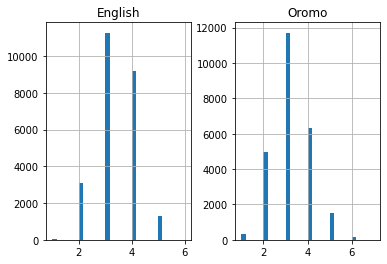

In [ ]:
# empty lists for English and Afaan-Oromo semtences
eng_l = []
oro_l = []

# populate the lists with sentence lengths
for i in clean_pairs [:,0]:
      eng_l.append(len(i.split()))

for i in clean_pairs [:,1]:
     oro_l.append(len(i.split()))

length_df = pd.DataFrame({'English':eng_l, 'Oromo':oro_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('english-oromo.txt')
 
# reduce dataset size to speed up training in demonstration
n_sentences = 36000 
dataset = raw_dataset[:n_sentences, :]

# random shuffle
shuffle(dataset)

# split into train/test
ntest=dataset.shape[0]//5
train, test = dataset[:-ntest], dataset[-ntest:]
print(train.shape,test.shape)

# save
save_clean_data(dataset, 'english-oromo-both.pkl')
save_clean_data(train, 'english-oromo-train.pkl')
save_clean_data(test, 'english-oromo-test.pkl')

(20000, 2) (5000, 2)
Saved: english-oromo-both.pkl
Saved: english-oromo-train.pkl
Saved: english-oromo-test.pkl


In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y
 
# load datasets
dataset = load_clean_sentences('english-oromo-both.pkl')
train = load_clean_sentences('english-oromo-train.pkl')
test = load_clean_sentences('english-oromo-test.pkl')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare french tokenizer
oro_tokenizer = create_tokenizer(dataset[:, 1])
oro_vocab_size = len(oro_tokenizer.word_index) + 1
oro_length = max_length(dataset[:, 1])
print('Oromo Vocabulary Size: %d' % oro_vocab_size)
print('Oromo Max Length: %d' % (oro_length))
 
# prepare training data
trainX = encode_sequences(oro_tokenizer, oro_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare test data
testX = encode_sequences(oro_tokenizer,oro_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

English Vocabulary Size: 4329
English Max Length: 6
Oromo Vocabulary Size: 10509
Oromo Max Length: 7


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 512)            5380608   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 6, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 6, 512)            2099200   
                                                                 
 time_distributed (TimeDistr  (None, 6, 4329)          2220777   
 ibuted)                                                         
                                                                 
Total params: 11,799,785
Trainable params: 11,799,785
No

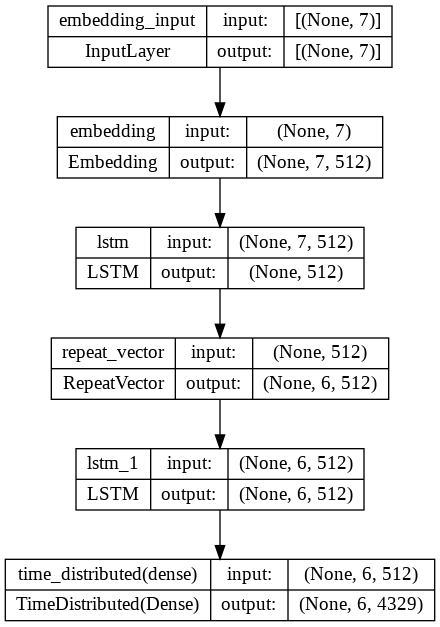

In [ ]:
 #define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	# source word embedding
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	# LSTMs to generate setence encoding
	model.add(LSTM(n_units))
	# repeat source encoding over target sequence
	model.add(RepeatVector(tar_timesteps))
	# LSTMs to generate target sentence
	model.add(LSTM(n_units, return_sequences=True))
	# Dense network to produce distribution over target vocabulary
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# define model
model = define_model(oro_vocab_size, eng_vocab_size, oro_length, eng_length, 512)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize defined model
print(model.summary())
plot_model(model, to_file='model1.png', show_shapes=True)

In [ ]:
# Fit model
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# set up a checkpoint to save the model each epoch
filename = 'model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit the model to the training data
history= model.fit(trainX, trainY, epochs=40, batch_size=512, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)

Epoch 1/40
39/40 [============================>.] - ETA: 0s - loss: 5.1991 - accuracy: 0.4366
Epoch 1: val_loss improved from inf to 3.83704, saving model to model.h1
40/40 [==============================] - 25s 473ms/step - loss: 5.1970 - accuracy: 0.4367 - val_loss: 3.8370 - val_accuracy: 0.4695
Epoch 2/40
39/40 [============================>.] - ETA: 0s - loss: 3.5330 - accuracy: 0.4733
Epoch 2: val_loss improved from 3.83704 to 3.43304, saving model to model.h1
40/40 [==============================] - 17s 427ms/step - loss: 3.5330 - accuracy: 0.4733 - val_loss: 3.4330 - val_accuracy: 0.4789
Epoch 3/40
39/40 [============================>.] - ETA: 0s - loss: 3.3192 - accuracy: 0.4854
Epoch 3: val_loss improved from 3.43304 to 3.35089, saving model to model.h1
40/40 [==============================] - 17s 423ms/step - loss: 3.3191 - accuracy: 0.4854 - val_loss: 3.3509 - val_accuracy: 0.4878
Epoch 4/40
39/40 [============================>.] - ETA: 0s - loss: 3.2335 - accuracy: 0.4948
E

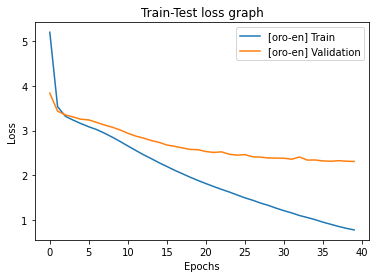

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train-Test loss graph')
plt.legend(['[oro-en] Train','[oro-en] Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

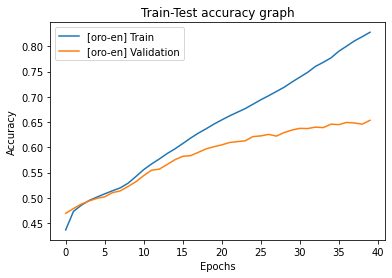

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train-Test accuracy graph')
plt.legend(['[oro-en] Train','[oro-en] Validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the performance of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
  actual, predicted = list(), list()
  for i, source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_target, raw_src = raw_dataset[i]
    if i < 10:
      print('Source==> [%s], Target==> [%s], Pred==> [%s]' % (raw_src, raw_target, translation))
    actual.append([raw_target.split()])
    predicted.append(translation.split())

  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-oromo-both.pkl')
train = load_clean_sentences('english-oromo-train.pkl')
test = load_clean_sentences('english-oromo-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

# prepare german tokenizer
deu_tokenizer = create_tokenizer(dataset[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = max_length(dataset[:, 1])

# prepare data
trainX = encode_sequences(deu_tokenizer,deu_length, train[:, 1])
testX = encode_sequences(deu_tokenizer,deu_length, test[:, 1])

# load model
model = load_model('model.h1')

# test on some training sequences
print('******************** Oromo Train Result:********************')
evaluate_model(model, eng_tokenizer, trainX, train)

# test on some test sequences
print('******************** Oromo Test Result:**********************')
evaluate_model(model, eng_tokenizer, testX, test)

******************** Oromo Train Result:********************
Source==> [isheenna na laaluu dhufte], Target==> [she came to see me], Pred==> [she sat to to me]
Source==> [ani faarfachuu nan jaalladha], Target==> [i like singing], Pred==> [i like to]
Source==> [oliin karaa namaa hin hilu], Target==> [oli isnt budging], Pred==> [oli isnt budging]
Source==> [namni tokkoyyuu sin jaallatu], Target==> [no one likes you], Pred==> [no one likes you]
Source==> [oliin didaadha], Target==> [oli is reluctant], Pred==> [oli is rude]
Source==> [daftee deebite], Target==> [youre back early], Pred==> [youre back early]
Source==> [nuti lola qabna turre], Target==> [we had a fight], Pred==> [we had in]
Source==> [akka namaatti qabsaaa], Target==> [fight like a man], Pred==> [you like a]
Source==> [kana naaf dhiisi], Target==> [leave it to me], Pred==> [let it to me]
Source==> [isin baayyee qaqalloodha], Target==> [youre so skinny], Pred==> [youre so skinny]
BLEU-1: 0.745968
BLEU-2: 0.653062
BLEU-3: 0.580

In [ ]:
print('*********************Train Result:*********************')
pred_df = pd.DataFrame({'Source': train[:, 1], 'Actual':train[:, 0], 'Predicted':trainX[:, 1] })
pd.set_option('display.max_colwidth', 100)
pred_df.head(10)

*********************Train Result:*********************


,Source,Actual,Predicted
0,isheenna na laaluu dhufte,she came to see me,20
1,ani faarfachuu nan jaalladha,i like singing,1337
2,oliin karaa namaa hin hilu,oli isnt budging,160
3,namni tokkoyyuu sin jaallatu,no one likes you,86
4,oliin didaadha,oli is reluctant,1869
5,daftee deebite,youre back early,1568
6,nuti lola qabna turre,we had a fight,1157
7,akka namaatti qabsaaa,fight like a man,2315
8,kana naaf dhiisi,leave it to me,36
9,isin baayyee qaqalloodha,youre so skinny,16


In [ ]:
print('********************* Test Result:*********************')
pred_df = pd.DataFrame({'Source':test[:, 1], 'Actual':test[:, 0], 'Predicted':testX[:,1]})
pd.set_option('display.max_colwidth', 100)
pred_df.head(10)

********************* Test Result:*********************


,Source,Actual,Predicted
0,olii kophaatu beeka,only oli knows,2291
1,ani isin gargaaruu nan dandaaa,may i help you,21
2,namni hundinuu ni qoosa,everybody lies,88
3,enyutu dadhabe,whos tired,349
4,akkamittan argachuu dandaa,how do i get one,474
5,foddaa kee bani,open your window,29
6,isaan nu jaallatan,they love us,60
7,konkolaataa as dhaabuu dandeessa,you may park here,38
8,sirrii hin turree,was that a no,3
9,kun dhimma kooti,its my job,197
